In [1]:
from misc import *
import numpy as np
from scipy.integrate import  odeint
import matplotlib as mtl

#mtl.use('nbAgg')
#mtl.use('Qt5Cairo')

import matplotlib.pyplot as plt



In [2]:
def g_calc(Funcs,Ysolni,h,ti,N):
    
    _f= lambda _y:np.array([  Funcs[i](_y,ti) for i in np.arange(N)])
    dfdt= np.array([  deriv(lambda _t:Funcs[i](Ysolni,_t),ti)  for i in np.arange(N)])
    
    Jac=jacobian(_f,Ysolni)
    M=np.eye(N)/(gam*h)-Jac
    L,U,P=LUP_dec(M)
    
    _c= np.array([_f(Ysolni)[i] for i in np.arange(N)])
    vg1=Solve_LU(L,U,P,_c)
    
    _f= lambda _y:np.array([  Funcs[i](_y,ti+c2*h) for i in np.arange(N)])
    _c= np.array([_f(Ysolni+r21/gam*vg1)[i] for i in np.arange(N)])+h*s2*dfdt-p21/gam*vg1/h
    vg2=Solve_LU(L,U,P,_c)
    
    _f= lambda _y:np.array([  Funcs[i](_y,ti+c3*h) for i in np.arange(N)])
    _c= np.array([_f(Ysolni+1/gam*(r31*vg1+r32*vg2))[i] for i in np.arange(N)])+h*s3*dfdt\
    -p31/gam*vg1/h-p32/gam*vg2/h
    vg3=Solve_LU(L,U,P,_c)
    
    return vg1,vg2,vg3







def ROS3w(Funcs,y0,t0,t1,rel_err0=1.e-3,err0=1.e-3,h=1.e-3,hmin=1.e-4,hmax=5.e-1,Nmax=5000,beta=.05):
    try:
        N=len(Funcs)
    except:
        Funcs=[Funcs]
        N=1
    Ysol=np.array([y0])
    tsteps=np.array([t0])
    tnext=t0
    
    n=0
    hnew=h
    errp=1
    err=1
    ERR=np.array([1])
    H=np.array([h,h])
    while n<Nmax and tsteps[n]<t1:
        while True:

            errp=err
            g1,g2,g3= g_calc(Funcs,Ysol[n],hnew,tsteps[n],N)
            ynext1 = Ysol[n]+1/gam*(q1*g1+q2*g2+q3*g3)
            ynext2 = Ysol[n]+1/gam*(qh1*g1+qh2*g2+qh3*g3)            
            delta=ynext1-ynext2
            scale=err0+rel_err0*np.max(np.abs(np.append(Ysol[n],ynext2)))
            dd=delta/scale

            err=np.max(np.abs(dd))
            if err>1  and (hnew<hmax and hnew>hmin):
                if err**(1/3.)>10**(-2/3.):
                    hnew=beta*hnew*(0.8/100)**(1/3.)
                else:
                    hnew=beta*hnew*(0.8/err)**(1/3.)
                

            else:
                if err**(1/4.)<10**(-1/4.):
                    hnew=beta*hnew*(1.2/0.1)**(1/4.)
                else:
                    hnew=beta*hnew*(1.2/err)**(1/4.)*(errp/err)**(1/4.)

                
                break
                
        if hnew>hmax:    
            hnew=hmax
            
        if hnew<hmin:
            hnew=hmin
        

        g1,g2,g3= g_calc(Funcs,Ysol[n],hnew,tsteps[n],N)
        ynext1 = Ysol[n]+1/gam*(q1*g1+q2*g2+q3*g3)
        ynext2 = Ysol[n]+1/gam*(qh1*g1+qh2*g2+qh3*g3)
        Ysol=np.vstack((Ysol[:],ynext2))
        tsteps=np.append(tsteps,tsteps[n]+hnew)
        
        ERR=np.append(ERR,err)
        n+=1
    print( n )   
    return tsteps, Ysol,ERR

In [3]:
def dxdt(r,t):
    x=r[0]
    y=r[1]
    return np.sin(x**2-y**2)/(t+1)/10
def dydt(r,t):
    x=r[0]
    y=r[1]
    return np.exp(-3*(t-4)**2-x**2)*10

In [4]:
x0,y0=1,.1

%time t,y,E=ROS3w([dxdt,dydt],[x0,y0],0,20,rel_err0=1.e-5,err0=1.e-5,h=1.e-3,hmin=1.e-5,hmax=1.e-1,Nmax=5000,beta=0.9)


%time yf=odeint(lambda _r,_t:([dxdt(_r,_t),dydt(_r,_t)]) ,[x0,y0],t,mxstep=5000,atol=1.e-11,rtol=1.e-50)



rel_er1= np.array([np.abs((y[i,0]-yf[i,0])/yf[i,0]) for i in np.arange(len(t))  ])
rel_er2= np.array([np.abs((y[i,1]-yf[i,1])/yf[i,1]) for i in np.arange(len(t))  ])


588
CPU times: user 914 ms, sys: 418 µs, total: 914 ms
Wall time: 934 ms
CPU times: user 9.94 ms, sys: 0 ns, total: 9.94 ms
Wall time: 9.62 ms


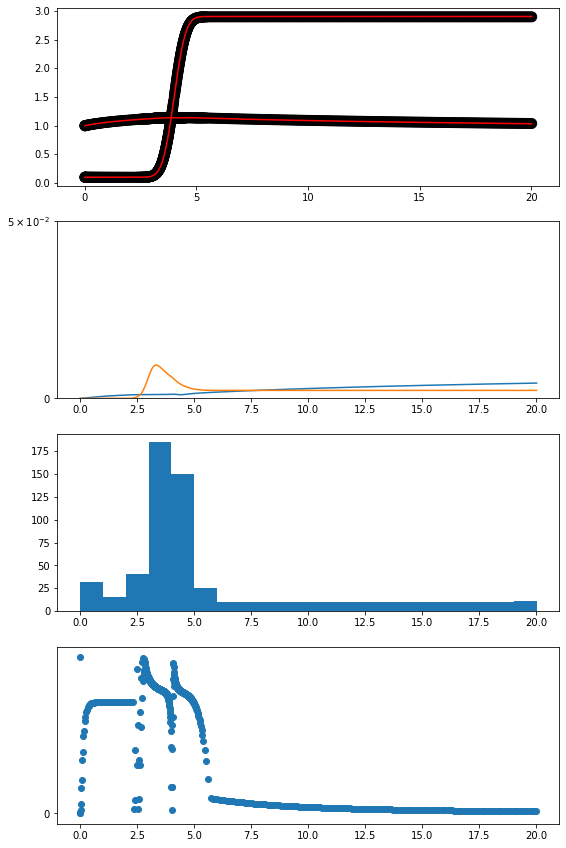

In [5]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(9, 15))
m_size=((t+1)/(t+1))*100

ax[0].scatter(t,y[:,0],color='black',marker='o',s=m_size)
ax[0].plot(t,yf[:,0],color='r')

ax[0].scatter(t,y[:,1],color='black',marker='o',s=m_size)
ax[0].plot(t,yf[:,1],color='r')

ax[1].plot(t,rel_er1)
ax[1].plot(t,rel_er2)
ax[1].set_yscale('symlog')
ax[1].set_ylim([0,0.05])

ax[2].hist(t,range=[np.min(t),np.max(t)],bins=20)
ax[3].scatter(t,E)
ax[3].set_yscale('symlog')

plt.show()